# I.Import et etudes fichiers

In [925]:
# installations et imports des autres packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import fonctions as fc

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,silhouette_samples
from sklearn.pipeline import Pipeline
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

In [926]:
# file path
data_file_path = "DATA\data_standard.csv"
standard = pd.read_csv(data_file_path)
# file path
data_file_path = "DATA\data_robust.csv"
robust = pd.read_csv(data_file_path)
# file path
data_file_path = "DATA\data_minmax.csv"
minmax = pd.read_csv(data_file_path)

# Feature enginering

In [927]:
nb_clusters = 9

In [928]:
# selection du poids de la colonne
poids_prod = 2
poids_exp = 1
poids_imp = 1
poids_dispo_int = 3
poids_disp_prot = 1
poids_pib = 2

In [929]:
# choix du datraframe
# data = robust
# data = standard
data = minmax

In [930]:
data.head()

,Zone,Disponibilité de protéines en quantité (kg/personne),Disponibilité intérieure/ Population,Exportations / Population,Importations / Population,Production / Population,Population,PIB US $ par habitant
0,Afghanistan,0.397574,0.266563,0.530050,0.532928,0.277960,0.111509,0.043979
1,Afrique du Sud,0.896025,0.470321,0.541643,0.774152,0.849252,0.175235,0.499026
2,Albanie,0.771880,0.627681,0.530050,0.811916,0.555392,0.008713,0.427950
3,Algérie,0.595273,0.350841,0.530050,0.253678,0.616369,0.127178,0.411931
4,Allemagne,0.808579,0.401911,0.768581,0.786301,0.775736,0.254147,0.838239


In [931]:
#Les colonnes à qui accorder le plus d'importance
data['Production / Population'] = np.exp(data['Production / Population']) * poids_prod
data['Exportations / Population'] = np.exp(data['Exportations / Population'])* poids_exp
data['Importations / Population'] = data['Importations / Population']* poids_imp
data['Disponibilité de protéines en quantité (kg/personne)'] = data['Disponibilité de protéines en quantité (kg/personne)'] * poids_disp_prot
data['PIB US $ par habitant'] = data['PIB US $ par habitant'] * poids_pib
data['Disponibilité intérieure/ Population'] = data['Disponibilité intérieure/ Population'] * poids_dispo_int

In [932]:
data_num = data.select_dtypes(include=[np.number])
pays = data['Zone']

# V.PCA

In [933]:
import pandas as pd
from sklearn.decomposition import PCA

def apply_pca(X):
    """
    Applique l'Analyse en Composantes Principales (ACP) sur les données X.

    Parameters:
        X (DataFrame): Les données d'entrée.

    Returns:
        pca (PCA): L'objet PCA ajusté.
    """
    # Créer les composantes principales
    pca = PCA()
    X_acp = pca.fit_transform(X)
    # Convertir en dataframe
    noms_composantes = [f"CP{i+1}" for i in range(X_acp.shape[1])]
    X_acp = pd.DataFrame(X_acp, columns=noms_composantes)
    # Créer les chargements
    chargements = pd.DataFrame(
        pca.components_.T,  # transposer la matrice des chargements
        columns=noms_composantes,  # les colonnes sont les composantes principales
        index=X.columns,  # les lignes sont les variables originales
    )
    return pca

def plot_variance(acp, largeur=8, dpi=100):
    """
    Trace les graphiques de la variance expliquée et cumulative de l'ACP.

    Parameters:
        acp (PCA): L'objet PCA ajusté.
        largeur (int): La largeur de la figure.
        dpi (int): La résolution de la figure.

    Returns:
        axs (array): Les axes des graphiques.
    """
    # Créer la figure
    fig, axs = plt.subplots(1, 2)
    n = acp.n_components_
    grille = np.arange(1, n + 1)
    # Variance expliquée
    variance_exp = acp.explained_variance_ratio_
    axs[0].bar(grille, variance_exp)
    axs[0].set(
        xlabel="Composante", title="% Variance Expliquée", ylim=(0.0, 1.0)
    )
    # Variance cumulative
    variance_cumul = np.cumsum(variance_exp)
    axs[1].plot(np.r_[0, grille], np.r_[0, variance_cumul], "o-")
    axs[1].set(
        xlabel="Composante", title="% Variance Cumulative", ylim=(0.0, 1.0)
    )
    # Configurer la figure
    fig.set(figwidth=largeur, dpi=dpi)
    return axs

In [934]:
pca = apply_pca(data_num)

array([<Axes: title={'center': '% Variance Expliquée'}, xlabel='Composante'>,
       <Axes: title={'center': '% Variance Cumulative'}, xlabel='Composante'>],
      dtype=object)

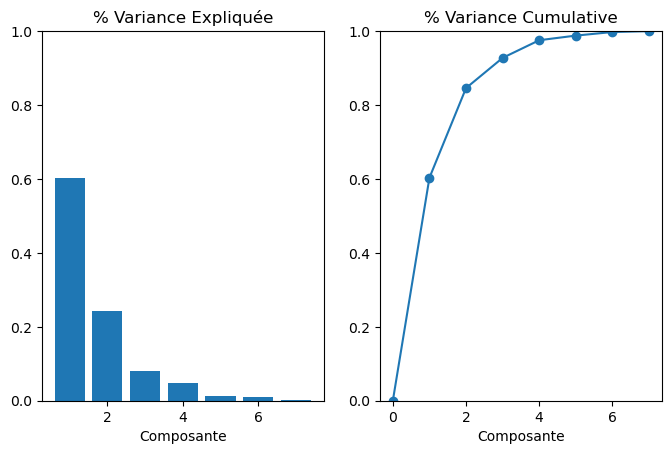

In [935]:
# Call the plot_variance function
plot_variance(pca)

Notre colonne F1 explique à elle seul 77% de l'information contneu dans nos données d'origine.

Nos deux colonnes F1 et F2 explique 87% de l'information contenu dans nos données d'origine.

Nos trois colonnes F1, F2 et F3 explique 96% de l'information contenu dans nos données d'origine.

## ACP 3 component

In [936]:
n_components = 3
pca = PCA(n_components=n_components)
pca.fit(data_num)

PCA(n_components=3)

In [937]:
# Obtenir les composantes principales
pcs = pca.components_

# Convertir les composantes principales en un DataFrame
pcs = pd.DataFrame(pcs)

# Définir les noms des colonnes du DataFrame comme les noms des variables originales
features = data_num.columns
pcs.columns = features

# Définir les index du DataFrame comme les noms des composantes principales (F1, F2)
x_list = list(range(1, len(pcs) + 1))
pcs.index = [f"F{i}" for i in x_list]

# Arrondir les valeurs du DataFrame à deux décimales
pcs.round(2)

,Disponibilité de protéines en quantité (kg/personne),Disponibilité intérieure/ Population,Exportations / Population,Importations / Population,Production / Population,Population,PIB US $ par habitant
F1,-0.16,-0.25,-0.10,-0.04,-0.85,-0.00,-0.42
F2,0.12,0.81,0.04,0.26,-0.41,-0.15,0.27
F3,-0.04,-0.40,0.39,0.03,-0.30,0.12,0.76


In [938]:
def plot_all_pca_correlation_circles(pca, features):
    n_components = pca.n_components_
    fig, axs = plt.subplots(n_components-1, n_components-1, figsize=(15, 15))

    for i in range(n_components):
        for j in range(i+1, n_components):
            ax = axs[i, j-1]  # j-1 car il n'y a pas de subplot pour i=j
            for k in range(0, pca.components_.shape[1]):
                ax.arrow(0, 0, pca.components_[i, k], pca.components_[j, k], head_width=0.07, head_length=0.07, width=0.02)
                ax.text(pca.components_[i, k] + 0.05, pca.components_[j, k] + 0.05, features[k])
            ax.plot([-1, 1], [0, 0], color='grey', ls='--')
            ax.plot([0, 0], [-1, 1], color='grey', ls='--')
            ax.set_xlabel('F{} ({}%)'.format(i+1, round(100*pca.explained_variance_ratio_[i],1)))
            ax.set_ylabel('F{} ({}%)'.format(j+1, round(100*pca.explained_variance_ratio_[j],1)))
            ax.set_title("Cercle des corrélations (F{} et F{})".format(i+1, j+1))
            an = np.linspace(0, 2 * np.pi, 100)
            ax.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale
            ax.axis('equal')

    plt.tight_layout()
    plt.show(block=False)

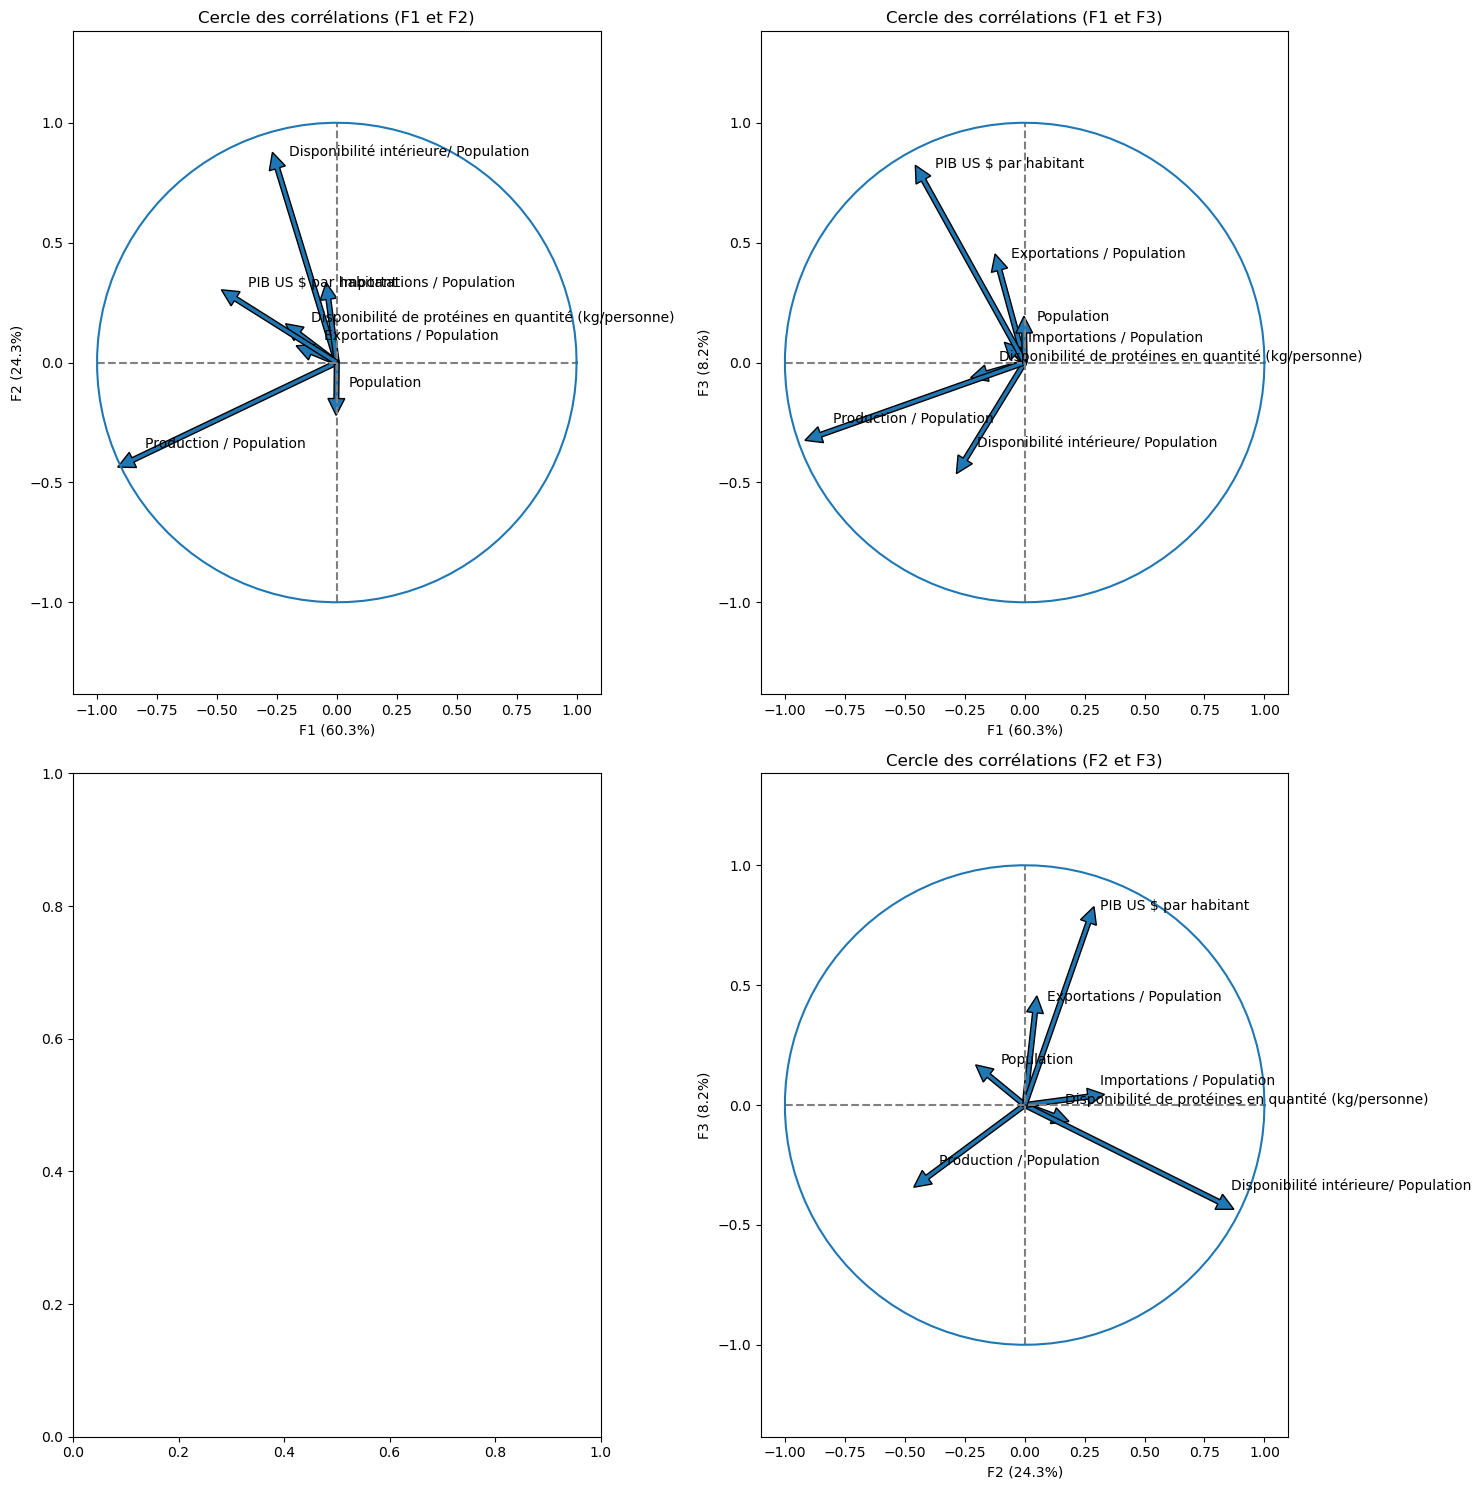

In [939]:
# Utilisation de la fonction
plot_all_pca_correlation_circles(pca, features)

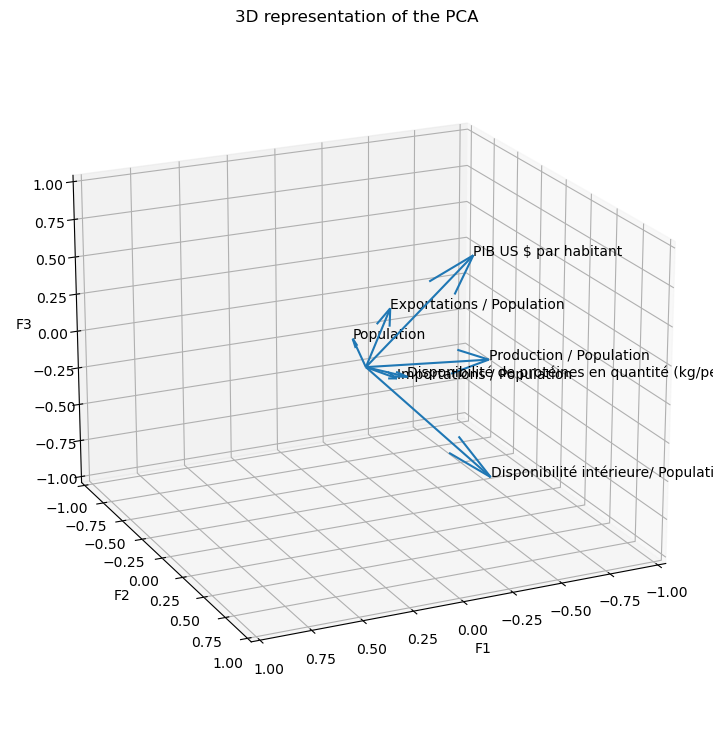

In [940]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 9))
ax = fig.add_subplot(111, projection='3d')

for i in range(pca.components_.shape[1]):
    ax.quiver(0, 0, 0,
              pca.components_[0, i], pca.components_[1, i], pca.components_[2, i])

    ax.text(pca.components_[0, i], pca.components_[1, i], pca.components_[2, i], features[i])

ax.set_xlabel('F1')
ax.set_ylabel('F2')
ax.set_zlabel('F3')
ax.set_title("3D representation of the PCA")

# Définir les limites des axes
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])

ax.view_init(elev=20, azim=65)
plt.show()

In [941]:
import plotly.graph_objects as go

scaling_factor = 1.5  # Adjust the scaling factor as desired

fig = go.Figure()

for i in range(pca.components_.shape[1]):
    # Add a line for the vector
    fig.add_trace(go.Scatter3d(
        x=[0, pca.components_[0, i] * scaling_factor],
        y=[0, pca.components_[1, i] * scaling_factor],
        z=[0, pca.components_[2, i] * scaling_factor],
        mode='lines',
        name=features[i]
    ))

    # Add a cone for the arrowhead
    fig.add_trace(go.Cone(
        x=[pca.components_[0, i] * scaling_factor],
        y=[pca.components_[1, i] * scaling_factor],
        z=[pca.components_[2, i] * scaling_factor],
        u=[pca.components_[0, i] * scaling_factor],
        v=[pca.components_[1, i] * scaling_factor],
        w=[pca.components_[2, i] * scaling_factor],
        sizemode="absolute",
        sizeref=0.2,
        anchor="cm"
    ))

fig.update_layout(
    title="3D representation of the PCA",
    scene=dict(
        xaxis_title='F1',
        yaxis_title='F2',
        zaxis_title='F3',
        aspectratio=dict(x=1, y=1, z=1),
        camera=dict(eye=dict(x=1.2, y=1.2, z=0.6))
    ),
    legend=dict(
        yanchor="top",
        y=0.1,
        xanchor="left",
        x=0.001
    )
)

fig.show()

In [942]:
import plotly.graph_objects as go

principal_components_pivot = pca.fit_transform(data_num)

fig = go.Figure(data=[go.Scatter3d(
    x=principal_components_pivot[:, 0],
    y=principal_components_pivot[:, 1],
    z=principal_components_pivot[:, 2],
    mode='markers',
    marker=dict(
        size=5,
        opacity=0.8
    )
)])

fig.update_layout(
    title='ACP - Vue en 3D',
    scene = dict(
        xaxis_title='Composante principale 1',
        yaxis_title='Composante principale 2',
        zaxis_title='Composante principale 3'
    )
)

fig.show()

In [943]:
X_proj = pca.transform(data_num)
df = pd.DataFrame(X_proj, columns = ["F1", "F2","F3"])
df_test = df.copy()
df.head()

,F1,F2,F3
0,1.674692,-0.453087,0.035521
1,-0.680893,-0.428009,-0.129397
2,0.295187,0.419383,-0.090926
3,0.375498,-0.536980,0.156832
4,-0.667215,-0.279339,0.752458


# PIPE  

## Dendogramme

In [944]:
# # Créer le pipeline pour le dendogramme
# pipe_dendogramme = Pipeline([
#     ('scaler', StandardScaler()),
#     ('agg', AgglomerativeClustering(n_clusters=nb_clusters, linkage='ward'))
# ])


# def create_dendrogram(df, pipe_dendogramme):
#     """Crée et affiche un dendrogramme pour un DataFrame donné, en utilisant un pipeline donné."""
#     Z = linkage(pipe_dendogramme['scaler'].transform(df), method='ward')
#     clusters = fcluster(Z, 3, criterion='maxclust')
#     plt.figure(figsize=(10, 7))
#     dendrogram(Z)
#     plt.show()

In [945]:
# # Ajuster le pipeline
# pipe_dendogramme.fit(df)
# create_dendrogram(df, pipe_dendogramme)

## Kmeans

In [946]:
# # créer le pipeline pour le kmeans
# pipe_kmeans = Pipeline([
#     ('scaler', StandardScaler()),
#     ('kmeans', KMeans(n_clusters=nb_clusters, random_state=0))
# ])

In [947]:
# # ajuster le pipeline]
# pipe_kmeans.fit(df)

# IV.Dendogramme

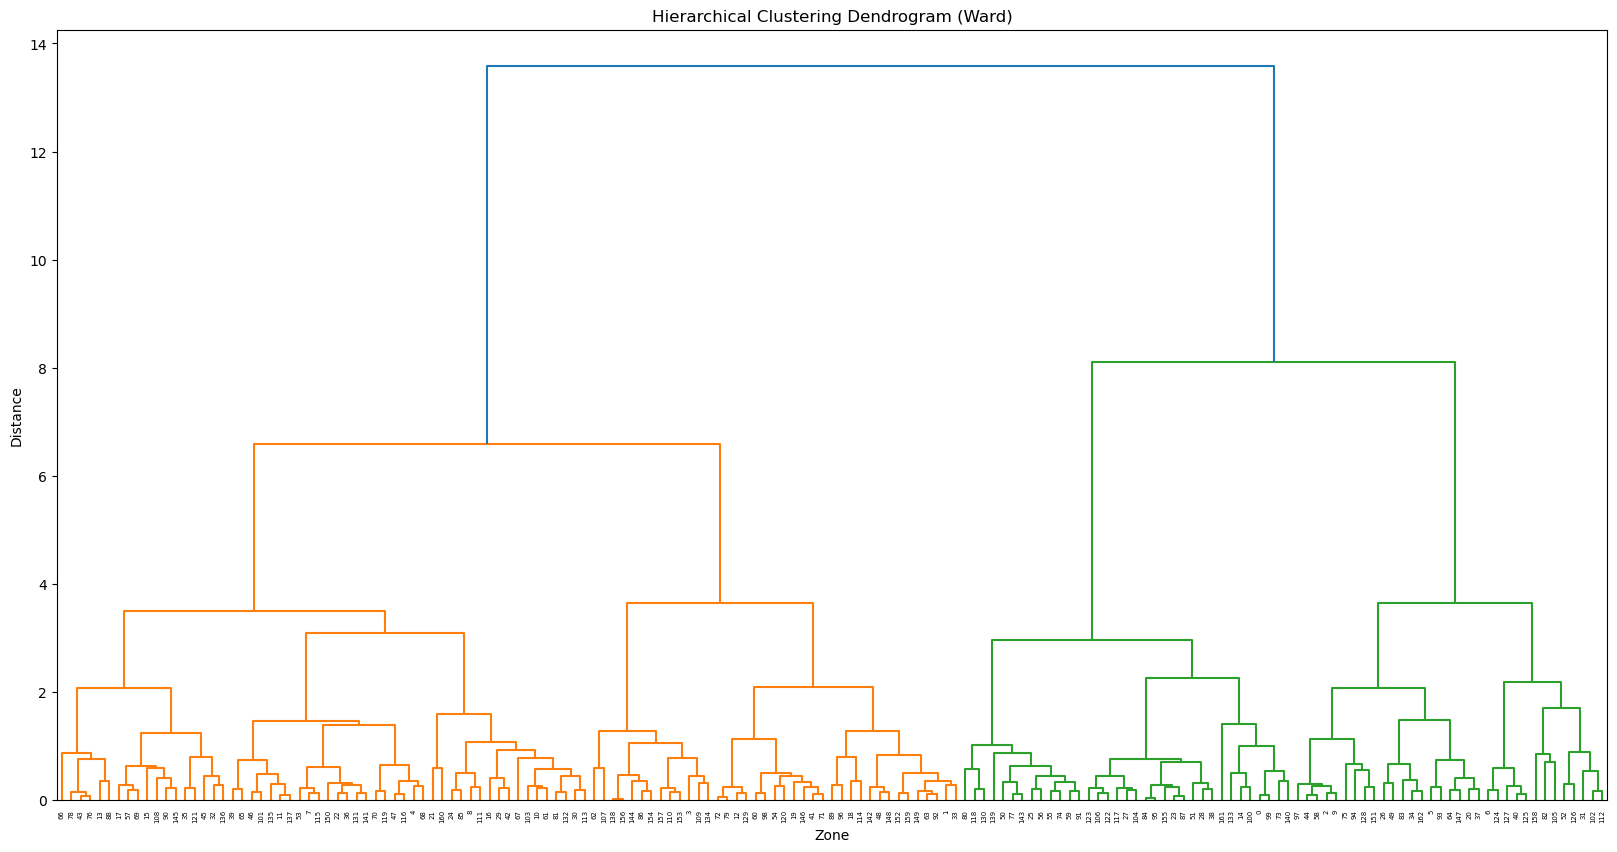

In [948]:
# création du modèle
Z = linkage(df, 'ward')

# Afficher le dendrogramme
plt.figure(figsize=(20, 10))
plt.title('Hierarchical Clustering Dendrogram (Ward)')
plt.xlabel('Zone')
plt.ylabel('Distance')
dendrogram(Z,  leaf_rotation=90)
plt.show()

In [949]:
# Coupage du dendrogramme en clusters
clusters = fcluster(Z, nb_clusters, criterion='maxclust')

# VI.Kmeans

In [950]:
# Import the os module
import os
# Set the environment variable 'OMP_NUM_THREADS' to '1'
os.environ['OMP_NUM_THREADS'] = '1'

c:\Users\antoi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



c:\Users\antoi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\antoi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\antoi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\antoi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than 

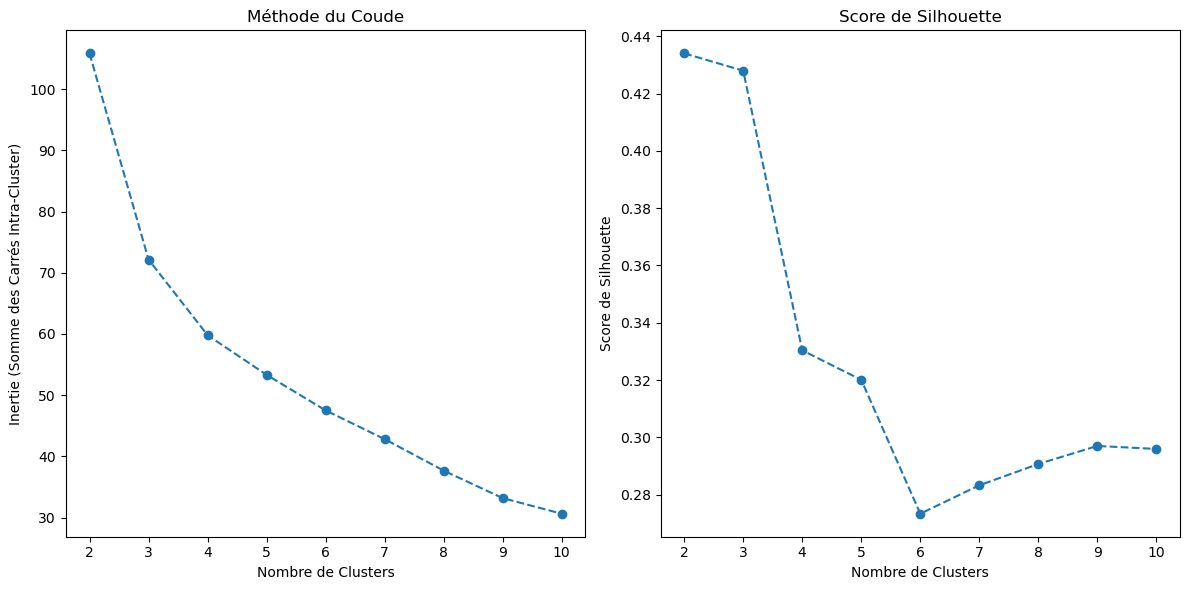

In [951]:
# Définir une plage de nombres de clusters à tester
plage_de_clusters = range(2, 11) 

# Listes pour stocker l'inertie et les scores de silhouette
valeurs_inertie = []
scores_silhouette = []

# Itérer à travers différents nombres de clusters et ajuster K-Means
for n_clusters in plage_de_clusters:
    kmeans_pivot = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
    clusters_pivot = kmeans_pivot.fit_predict(df_test)

    # Calculer l'inertie (somme des carrés intra-cluster)
    valeurs_inertie.append(kmeans_pivot.inertia_)

    # Calculer le score de silhouette
    scores_silhouette.append(silhouette_score(df_test, clusters_pivot))

# Tracer la méthode du coude pour déterminer le nombre optimal de clusters
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(plage_de_clusters, valeurs_inertie, marker='o', linestyle='--')
plt.xlabel('Nombre de Clusters')
plt.ylabel('Inertie (Somme des Carrés Intra-Cluster)')
plt.title('Méthode du Coude')

# Tracer le Score de Silhouette pour déterminer le nombre optimal de clusters
plt.subplot(1, 2, 2)
plt.plot(plage_de_clusters, scores_silhouette, marker='o', linestyle='--')
plt.xlabel('Nombre de Clusters')
plt.ylabel('Score de Silhouette')
plt.title('Score de Silhouette')

plt.tight_layout()
plt.show()

Méthode du Coude (Elbow Method) :

La Méthode du Coude consiste à trouver le point dans un graphique de l'inertie où la diminution de l'inertie ralentit, formant un coude.
Ce point représente généralement le nombre optimal de clusters dans une analyse de clustering.

Score de Silhouette (Silhouette Score) :

Le Score de Silhouette mesure à quel point les points d'un cluster sont similaires entre eux et différents des autres clusters.
Il varie de -1 à 1, où un score élevé indique une meilleure séparation des clusters.
Le nombre optimal de clusters est généralement celui qui donne le score de silhouette le plus élevé.

In [952]:
# Importer la classe KMeans du module sklearn.cluster
from sklearn.cluster import KMeans

# Créer une instance de la classe KMeans avec 2 clusters
kmeans = KMeans(n_clusters=nb_clusters, n_init=10, random_state=42)

# Entraîner le modèle KMeans sur les données numériques
kmeans.fit(df_test)

c:\Users\antoi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



KMeans(n_clusters=9, n_init=10, random_state=42)

On va cherche les labels de nôre Kmeans afin d'attribuer plus tard un cluster à chaque pays

In [953]:
# Obtenir les labels attribués par KMeans à chaque échantillon
labels = kmeans.labels_
labels[:10]

array([2, 0, 4, 5, 6, 1, 3, 8, 6, 4])

In [954]:
# Ajouter la colonne 'cluster_kmeans' au dataframe 'data' avec les labels attribués par KMeans
df['cluster_kmeans'] = kmeans.labels_

In [955]:
import plotly.express as px

fig = px.scatter_3d(df, x='F1', y='F2', z='F3', color='cluster_kmeans', color_continuous_scale='Viridis')

fig.update_layout(title='Graphique des clusters en 3D')
fig.show()

In [956]:
centroids = kmeans.cluster_centers_
centroids

array([[-0.41906397, -0.32489769, -0.2675423 ],
       [ 1.15364173,  0.18420392, -0.07537642],
       [ 1.37275437, -0.54918164,  0.12896348],
       [ 0.1765285 ,  1.41005158,  0.06758536],
       [ 0.39837795,  0.53711692, -0.0450897 ],
       [ 0.49859528, -0.5177908 , -0.16147223],
       [-0.96367362, -0.47361186,  0.36038108],
       [-1.2060097 ,  0.04691763, -0.23545372],
       [-0.64842805,  0.29090631,  0.26462683]])

In [957]:
import plotly.graph_objects as go

fig = px.scatter_3d(df, x='F1', y='F2', z='F3', color='cluster_kmeans', color_continuous_scale='Viridis')

# Ajouter les centroïdes au graphique
fig.add_trace(go.Scatter3d(x=centroids[:, 0], y=centroids[:, 1], z=centroids[:, 2], 
                           mode='markers',
                           marker=dict(size=10, color='red'), 
                           name='centroids'))

fig.update_layout(title='Graphique des clusters en 3D')
fig.show()

# Reconstruction de notre df apres le clustering

Comparaison de nos deux clusterings

In [958]:
# ajout de la colonne 'cluster_dd' au dataframe 'data' avec les labels attribués par le dendogramme
df['cluster_dd'] = clusters
# Ajouter la colonne 'cluster_kmeans' au dataframe 'data' avec les labels attribués par KMeans
df['cluster_kmeans'] = kmeans.labels_

In [959]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Créer une figure avec 2 subplots
fig = make_subplots(rows=1, cols=2, subplot_titles=('K-Means Clustering', 'Clustering basé sur le Dendrogramme'), specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}]])

# Ajouter le scatter plot pour le clustering K-Means au premier subplot
fig.add_trace(
    go.Scatter3d(x=df['F1'], y=df['F2'], z=df['F3'], mode='markers', marker=dict(color=df['cluster_kmeans'], size=5, colorscale='Viridis', opacity=0.8)),
    row=1, col=1
)

# Ajouter le scatter plot pour le clustering basé sur le dendrogramme au deuxième subplot
fig.add_trace(
    go.Scatter3d(x=df['F1'], y=df['F2'], z=df['F3'], mode='markers', marker=dict(color=df['cluster_dd'], size=5, colorscale='Viridis', opacity=0.8)),
    row=1, col=2
)

# Mettre à jour les layouts pour ajouter les labels d'axes
fig.update_layout(height=600, width=800)
fig.update_xaxes(title_text="Feature1", row=1, col=1)
fig.update_yaxes(title_text="Feature2", row=1, col=1)
fig.update_xaxes(title_text="Feature1", row=1, col=2)
fig.update_yaxes(title_text="Feature2", row=1, col=2)

fig.show()

Reconstruction de nos données d'origine en y ajoutant nos clusters

In [960]:
# Reconstruire les données d'origine
data_reconstructed = pca.inverse_transform(df_test)

# Conversion de l'array en DataFrame
data_reconstructed = pd.DataFrame(data_reconstructed)
column_names = data_num.columns
data_reconstructed.columns = column_names

data_reconstructed.head()

,Disponibilité de protéines en quantité (kg/personne),Disponibilité intérieure/ Population,Exportations / Population,Importations / Population,Production / Population,Population,PIB US $ par habitant
0,0.402736,0.803935,1.568510,0.483765,2.627585,0.154413,0.146606
1,0.784924,1.474886,1.753097,0.567141,4.670296,0.134845,1.021983
2,0.730490,1.903602,1.702137,0.757894,3.484416,0.010409,0.864685
3,0.592396,1.009162,1.747858,0.511392,3.729988,0.184423,0.765028
4,0.761321,1.235927,2.097744,0.636756,4.332701,0.220998,1.727164


In [961]:
#Les colonnes à qui accorder le plus d'importance
data['Production / Population'] = np.log(data['Production / Population']) / poids_prod
data['Exportations / Population'] = np.log(data['Exportations / Population'])/ poids_exp
data['Importations / Population'] = data['Importations / Population']/poids_imp
data['Disponibilité de protéines en quantité (kg/personne)'] = data['Disponibilité de protéines en quantité (kg/personne)'] / poids_disp_prot
data['PIB US $ par habitant'] = data['PIB US $ par habitant'] / poids_pib
data['Disponibilité intérieure/ Population'] = data['Disponibilité intérieure/ Population'] / poids_dispo_int

In [962]:
data_reconstructed.drop(['Production / Population'], axis=1, inplace=True)

In [963]:
# on va rapprocher nos clusters avec le dataframe initial
data_reconstructed['cluster_kmeans'] = df['cluster_kmeans']  
data_reconstructed['cluster_dd'] = df['cluster_dd']
data_reconstructed['Pays'] = pays
# Déplace les colonnes en premier 
data_reconstructed = data_reconstructed.set_index(['Pays', 'cluster_kmeans', 'cluster_dd']).reset_index()
data_reconstructed.head()

,Pays,cluster_kmeans,cluster_dd,Disponibilité de protéines en quantité (kg/personne),Disponibilité intérieure/ Population,Exportations / Population,Importations / Population,Population,PIB US $ par habitant
0,Afghanistan,2,7,0.402736,0.803935,1.568510,0.483765,0.154413,0.146606
1,Afrique du Sud,0,5,0.784924,1.474886,1.753097,0.567141,0.134845,1.021983
2,Albanie,4,8,0.730490,1.903602,1.702137,0.757894,0.010409,0.864685
3,Algérie,5,4,0.592396,1.009162,1.747858,0.511392,0.184423,0.765028
4,Allemagne,6,2,0.761321,1.235927,2.097744,0.636756,0.220998,1.727164


In [964]:
# Calculate the absolute differences between the original dataframe and the reconstructed dataframe
differences = abs(data_num - data_reconstructed.drop(['cluster_kmeans', 'cluster_dd', 'Pays'], axis=1))

# Display the differences
print(differences.mean().sort_values(ascending=False))

Exportations / Population                               0.174877
Importations / Population                               0.097813
PIB US $ par habitant                                   0.075679
Population                                              0.073318
Disponibilité de protéines en quantité (kg/personne)    0.059520
Disponibilité intérieure/ Population                    0.034103
Production / Population                                      NaN
dtype: float64


In [965]:
explained_variance = pca.explained_variance_ratio_.sum()
explained_variance

0.9276001219765894

In [966]:
# Modification du type des colonnes 'cluster_kmeans' et 'cluster_dd' en 'str'
data_reconstructed['cluster_kmeans'] = data_reconstructed['cluster_kmeans'].astype(str)
data_reconstructed['cluster_dd'] = data_reconstructed['cluster_dd'].astype(str)
data_recontructed_num = data_reconstructed.select_dtypes(include=[np.number])

# Evaluation des clusters


## Score de silhouette

### Kmeans

Score de silhouette moyen : 0.2970416986616299


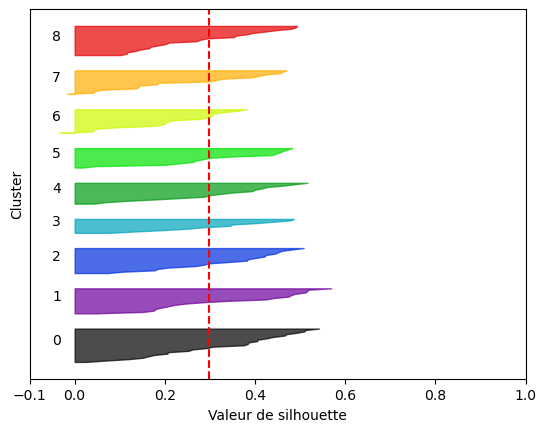

In [967]:
# Calculer le score de silhouette moyen
silhouette_avg = silhouette_score(df_test, labels)
print(f"Score de silhouette moyen : {silhouette_avg}")

# Calculer les scores de silhouette individuels pour chaque échantillon
sample_silhouette_values = silhouette_samples(df_test, labels)

# Créer un silhouette plot
fig, ax = plt.subplots()
y_lower = 10

for i in range(len(np.unique(labels))):
    # Aggrège les scores de silhouette pour les échantillons appartenant à un cluster particulier
    ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = plt.cm.nipy_spectral(float(i) / len(np.unique(labels)))
    ax.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Étiqueter chaque cluster avec son numéro au milieu
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Calculer la nouvelle position y_lower pour le prochain plot
    y_lower = y_upper + 10

ax.set_xlabel("Valeur de silhouette")
ax.set_ylabel("Cluster")
ax.axvline(x=silhouette_avg, color="red", linestyle="--")
ax.set_yticks([])
ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
plt.show()


### Dendogramme

Score de silhouette moyen : 0.2778344285173204


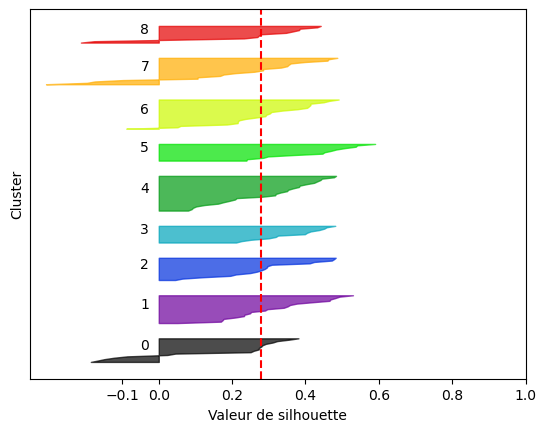

In [968]:
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_samples, silhouette_score

# Réorganiser les numéros de cluster pour qu'ils soient continus de 0 à 1
clusters = clusters - 1

# Calculer le score de silhouette moyen
silhouette_avg = silhouette_score(df_test, clusters)
print(f"Score de silhouette moyen : {silhouette_avg}")

# Calculer les scores de silhouette individuels pour chaque échantillon
sample_silhouette_values = silhouette_samples(df_test, clusters)

# Créer un silhouette plot
fig, ax = plt.subplots()
y_lower = 10

for i in range(len(np.unique(clusters))):
    # Aggrège les scores de silhouette pour les échantillons appartenant à un cluster particulier
    ith_cluster_silhouette_values = sample_silhouette_values[clusters == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = plt.cm.nipy_spectral(float(i) / len(np.unique(clusters)))
    ax.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Étiqueter chaque cluster avec son numéro au milieu
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Calculer la nouvelle position y_lower pour le prochain plot
    y_lower = y_upper + 10

ax.set_xlabel("Valeur de silhouette")
ax.set_ylabel("Cluster")
ax.axvline(x=silhouette_avg, color="red", linestyle="--")
ax.set_yticks([])
ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
plt.show()

## ARI

In [969]:
# Importer la fonction adjusted_rand_score du module sklearn.metrics
from sklearn.metrics import adjusted_rand_score

# Obtenir les labels attribués par KMeans et le dendrogramme
labels_kmeans = kmeans.labels_
labels_dendrogramme = clusters

# Calculer l'Indice de Rand Ajusté (ARI) en comparant les deux ensembles de labels
ari = adjusted_rand_score(labels_kmeans, labels_dendrogramme)

# Afficher le résultat
print("Indice de Rand Ajusté :", ari)


Indice de Rand Ajusté : 0.633108426320386


# Etude des clusters

### Fonctions pour l'étude des clusters

In [970]:
from math import pi

def get_cluster_data(data, cluster_column, cluster_value):
    """Renvoie un sous-ensemble de données pour le cluster spécifié."""
    return data[data[cluster_column] == cluster_value]

def radar_plot(*cluster_data_list):
    """Crée un radar plot pour les variables numériques de plusieurs clusters."""
    for i, cluster_data in enumerate(cluster_data_list):
        numeric_columns = cluster_data.select_dtypes(include='number').columns
        stats = cluster_data[numeric_columns].mean().tolist()
        stats += stats[:1]  # repeat the first value to close the circular graph
        angles = [n / float(len(numeric_columns)) * 2 * pi for n in range(len(numeric_columns))]
        angles += angles[:1]
        plt.polar(angles, stats, label=f'Cluster {i+1}')  # Ajoutez un label à chaque plot
        plt.fill(angles, stats, alpha=0.1)
    plt.xticks(angles[:-1], numeric_columns)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # Ajoutez une légende à droite du graphique
    plt.show() 

def plot_boxplot(data):
    """Crée un boxplot pour toutes les colonnes numériques côte à côte."""
    numeric_columns = data.select_dtypes(include='number').columns
    sns.boxplot(data=data[numeric_columns])
    plt.xticks(rotation=90)  # Rotation des étiquettes sur l'axe des x pour une meilleure lisibilité
    plt.show()
    
def radar_plot_subplot(cluster_data_list, ax):
    """Crée un radar plot pour les variables numériques de plusieurs clusters."""
    max_val = None
    for cluster_data in cluster_data_list:
        numeric_columns = cluster_data.select_dtypes(include='number').columns
        stats = cluster_data[numeric_columns].mean().tolist()
        if max_val is None or max(stats) > max_val:
            max_val = max(stats)  # Mettre à jour la valeur maximale
        stats += stats[:1]  # repeat the first value to close the circular graph
        angles = [n / float(len(numeric_columns)) * 2 * pi for n in range(len(numeric_columns))]
        angles += angles[:1]
        ax.plot(angles, stats)  # Utilisez plot au lieu de polar
        ax.fill(angles, stats, alpha=0.1)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(numeric_columns)
    ax.set_ylim(0, max_val)  # Définir les limites de l'axe y

def plot_boxplot_subplot(data, ax):
    """Crée un boxplot pour toutes les colonnes numériques côte à côte."""
    numeric_columns = data.select_dtypes(include='number').columns
    sns.boxplot(data=data[numeric_columns], ax=ax)
    ax.set_xticklabels(numeric_columns, rotation=90)  # Rotation des étiquettes sur l'axe des x pour une meilleure lisibilité

def plot_subplots(cluster_data_list, data):
    """Crée un subplot avec un radar plot et un boxplot."""
    fig = plt.figure(figsize=(12, 6))
    ax1 = fig.add_subplot(121, polar=True)
    ax2 = fig.add_subplot(122)
    radar_plot_subplot(cluster_data_list, ax1)
    plot_boxplot_subplot(data, ax2)
    plt.show()
    
def descriptive_statistics(cluster_data):
    """Affiche les statistiques descriptives pour les colonnes numériques du cluster."""
    numeric_columns = cluster_data.select_dtypes(include='number')
    print(numeric_columns.describe())
    
def analyze_cluster(data, cluster_column, cluster_value):
    """Analyse un cluster spécifié en appelant toutes les fonctions."""
    cluster_data = get_cluster_data(data, cluster_column, cluster_value)
    print('Boxplot et radarplot pour le cluster', cluster_value)
    plot_subplots([cluster_data], data)
    # print("Boxplot des colonnes numériques :")
    # plot_boxplot(cluster_data)
    # print("Radar plot des colonnes numériques :")
    # radar_plot(cluster_data)
    # print("Statistiques descriptives des colonnes numériques :")
    # descriptive_statistics(cluster_data)    

Création des datframes à partir des clusters

In [971]:
from scipy import cluster
# Créez des DataFrames pour chaque cluster Kmeans
cluster_kmeans_dfs = []
for i in range(nb_clusters):
    cluster_kmeans_df = get_cluster_data(data_reconstructed, 'cluster_kmeans', str(i))
    cluster_kmeans_dfs.append(cluster_kmeans_df)

# Créez des DataFrames pour chaque cluster dendogramme
cluster_dd_dfs = []
for i in range(nb_clusters):
    cluster_dd_df = get_cluster_data(data_reconstructed, 'cluster_dd', str(i))
    cluster_dd_dfs.append(cluster_dd_df)

### Etude global des clusters

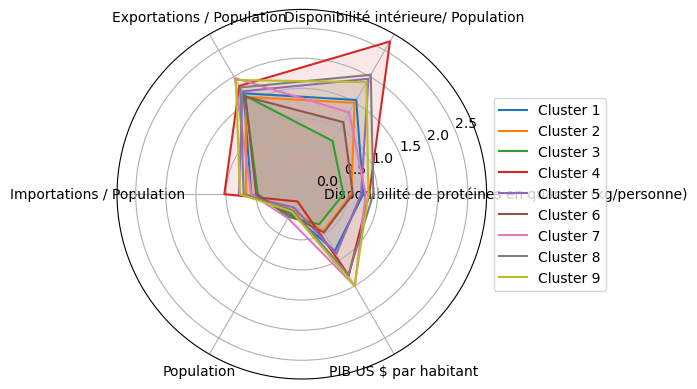

In [973]:
radar_plot(cluster_kmeans_dfs[0], cluster_kmeans_dfs[1], cluster_kmeans_dfs[2], cluster_kmeans_dfs[3], cluster_kmeans_dfs[4], cluster_kmeans_dfs[5], cluster_kmeans_dfs[6], cluster_kmeans_dfs[7], cluster_kmeans_dfs[8])

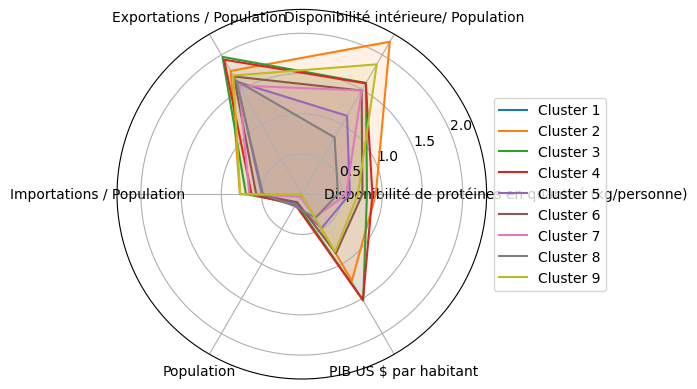

In [974]:
radar_plot(cluster_dd_dfs[0], cluster_dd_dfs[1], cluster_dd_dfs[2], cluster_dd_dfs[3], cluster_dd_dfs[4], cluster_dd_dfs[5], cluster_dd_dfs[6], cluster_dd_dfs[7], cluster_dd_dfs[8])

## Kmeans

### CLuster Kmeans 1

Boxplot et radarplot pour le cluster 0


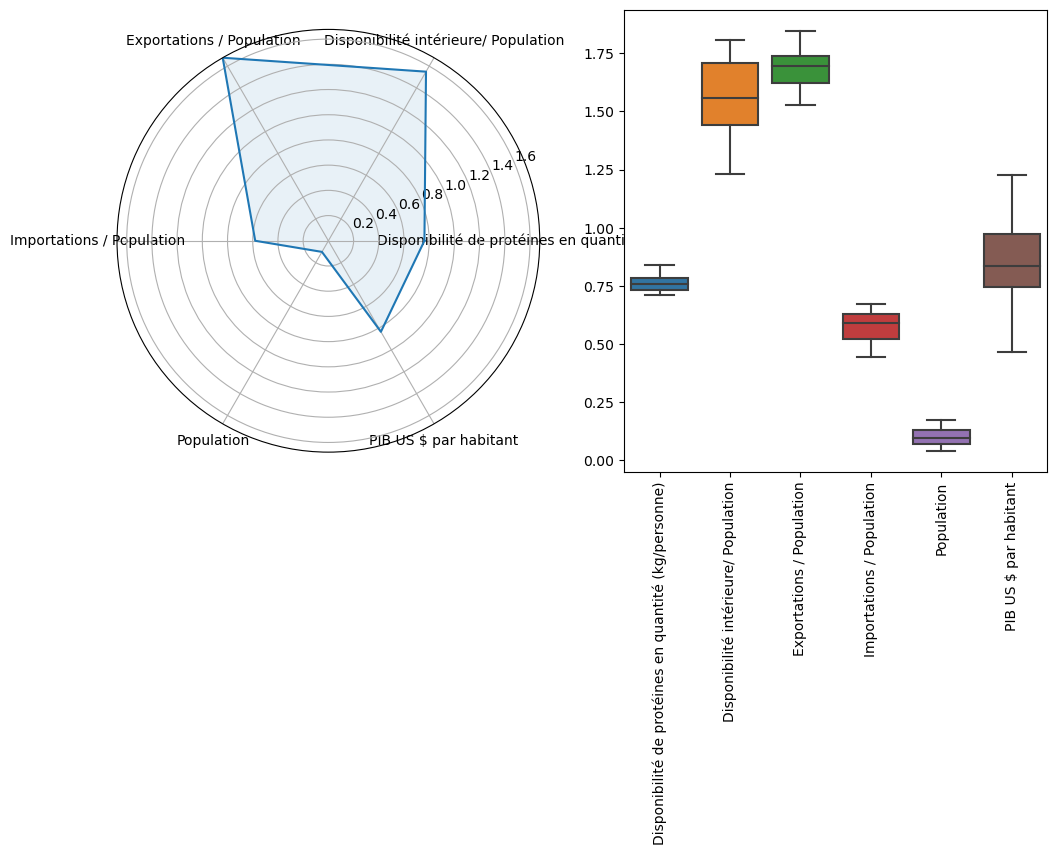

In [975]:
analyze_cluster(cluster_kmeans_dfs[0], 'cluster_kmeans', '0')

In [976]:
cluster_kmeans_dfs[0].describe()

,Disponibilité de protéines en quantité (kg/personne),Disponibilité intérieure/ Population,Exportations / Population,Importations / Population,Population,PIB US $ par habitant
count,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000
mean,0.762071,1.549233,1.676882,0.580341,0.101856,0.833717
std,0.036881,0.170731,0.085953,0.063180,0.037762,0.182869
min,0.711203,1.229839,1.528519,0.446044,0.041306,0.467984
25%,0.732384,1.440796,1.624535,0.519766,0.071446,0.745097
50%,0.760153,1.558869,1.694883,0.588522,0.098298,0.837753
75%,0.784924,1.708751,1.737762,0.631465,0.130574,0.972705
max,0.840772,1.808777,1.847005,0.671278,0.174735,1.226413


In [977]:
cluster_kmeans_dfs[0].head()

,Pays,cluster_kmeans,cluster_dd,Disponibilité de protéines en quantité (kg/personne),Disponibilité intérieure/ Population,Exportations / Population,Importations / Population,Population,PIB US $ par habitant
1,Afrique du Sud,0,5,0.784924,1.474886,1.753097,0.567141,0.134845,1.021983
12,Azerbaïdjan,0,5,0.716707,1.560311,1.694883,0.624757,0.086881,0.819339
18,Bolivie (État plurinational de),0,5,0.836282,1.708751,1.528519,0.528159,0.071446,0.608034
19,Bosnie-Herzégovine,0,5,0.805164,1.808777,1.713054,0.671278,0.057589,0.972705
33,Colombie,0,5,0.772156,1.440796,1.655509,0.519766,0.128515,0.795345


Ce cluster est les pays exportateur de poulet, pas intéressant pour notre étude

### Cluster Kmeans 2

Boxplot et radarplot pour le cluster 1


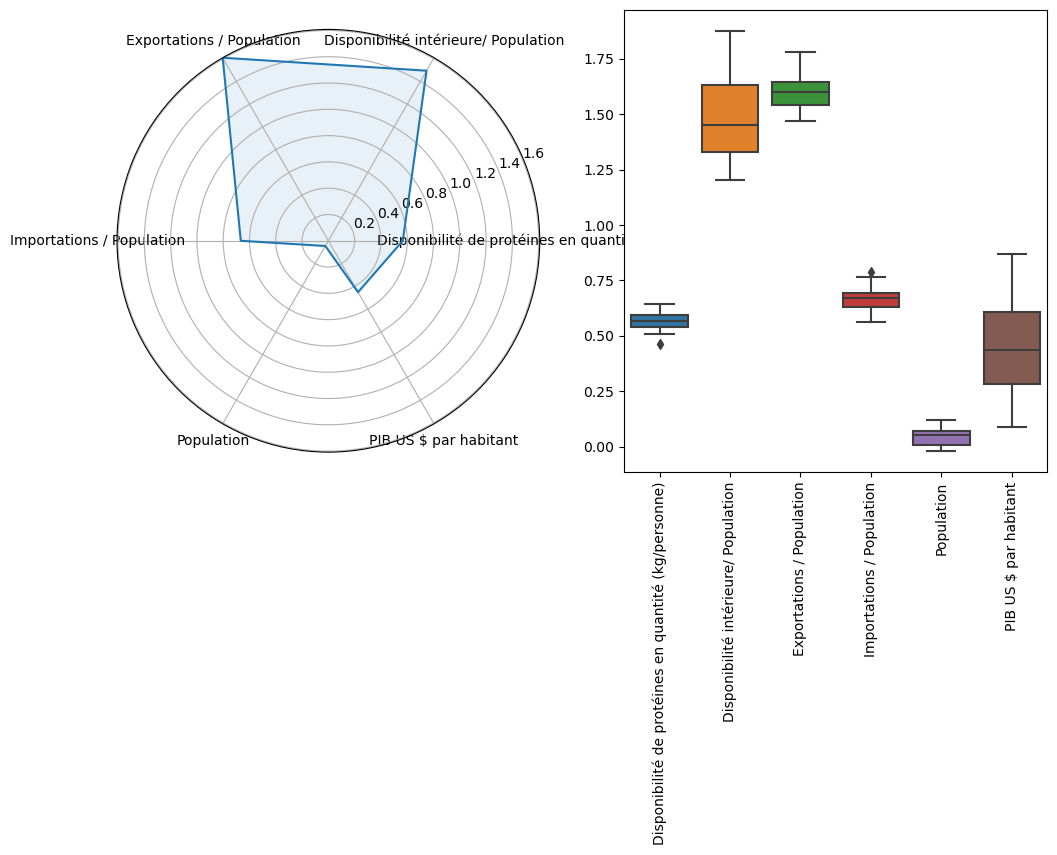

In [978]:
analyze_cluster(cluster_kmeans_dfs[1], 'cluster_kmeans', '1')

In [979]:
cluster_kmeans_dfs[1].describe()

,Disponibilité de protéines en quantité (kg/personne),Disponibilité intérieure/ Population,Exportations / Population,Importations / Population,Population,PIB US $ par habitant
count,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000
mean,0.566151,1.494009,1.607949,0.666303,0.046017,0.451621
std,0.045917,0.204372,0.093935,0.063026,0.042549,0.219792
min,0.461785,1.203863,1.471070,0.560284,-0.019125,0.086174
25%,0.541293,1.327064,1.542540,0.631497,0.007891,0.283385
50%,0.566873,1.450957,1.600073,0.671835,0.050055,0.433370
75%,0.594151,1.632818,1.643487,0.693737,0.072330,0.608248
max,0.642834,1.875916,1.780842,0.789342,0.117800,0.867517


In [980]:
cluster_kmeans_dfs[1].head()

,Pays,cluster_kmeans,cluster_dd,Disponibilité de protéines en quantité (kg/personne),Disponibilité intérieure/ Population,Exportations / Population,Importations / Population,Population,PIB US $ par habitant
5,Angola,1,8,0.566873,1.313727,1.775350,0.665367,0.106955,0.806022
25,Bénin,1,6,0.590464,1.578847,1.580843,0.671835,0.030608,0.425274
34,Congo,1,8,0.642834,1.833786,1.641756,0.765122,-0.007007,0.628335
50,Gambie,1,6,0.550312,1.582576,1.515502,0.673259,0.010122,0.237233
51,Ghana,1,7,0.548544,1.203863,1.686352,0.594827,0.117800,0.588355


### Cluster Kmeans 3

Boxplot et radarplot pour le cluster 2


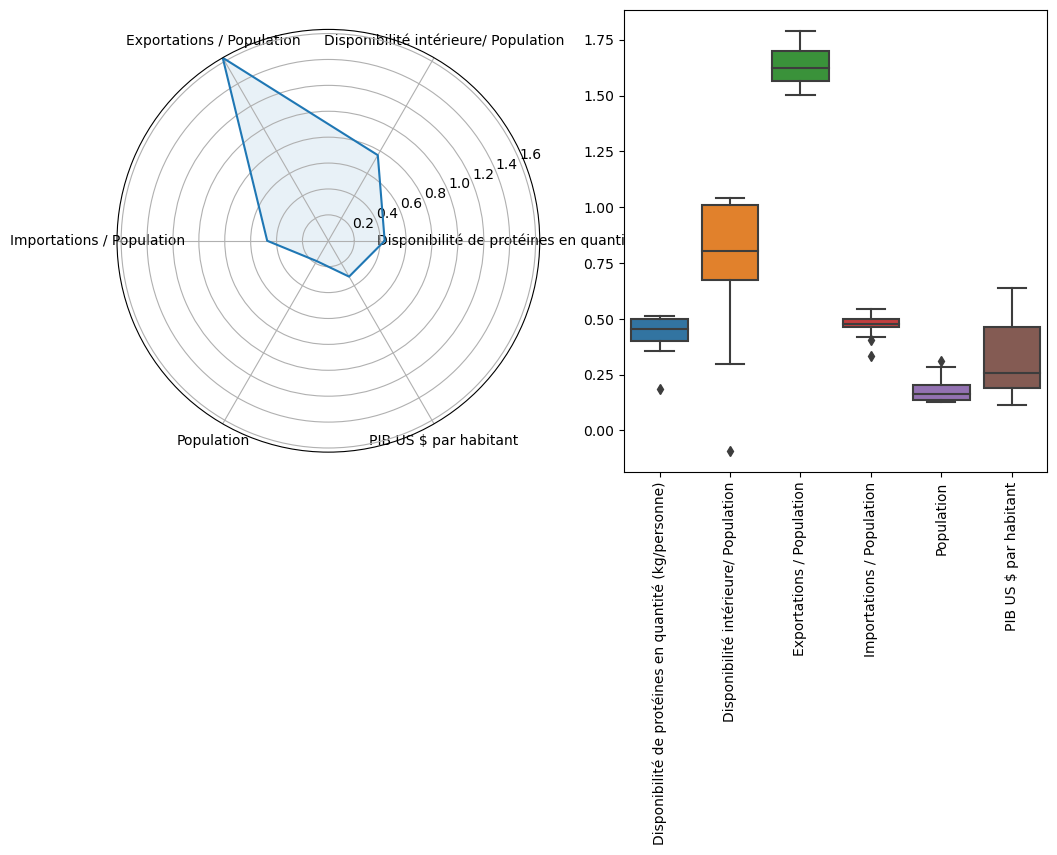

In [981]:
analyze_cluster(cluster_kmeans_dfs[2], 'cluster_kmeans', '2')

In [982]:
cluster_kmeans_dfs[2].describe()

,Disponibilité de protéines en quantité (kg/personne),Disponibilité intérieure/ Population,Exportations / Population,Importations / Population,Population,PIB US $ par habitant
count,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000
mean,0.434749,0.763259,1.632016,0.472257,0.180924,0.319632
std,0.079769,0.297400,0.087486,0.048316,0.055089,0.165560
min,0.185789,-0.091066,1.500527,0.331631,0.126405,0.111844
25%,0.398618,0.674001,1.564626,0.464066,0.136731,0.191605
50%,0.452467,0.803935,1.623027,0.477241,0.161685,0.259528
75%,0.499817,1.011445,1.699102,0.497582,0.205029,0.461766
max,0.513822,1.039562,1.790279,0.544220,0.313285,0.637807


In [983]:
cluster_kmeans_dfs[2].head()

,Pays,cluster_kmeans,cluster_dd,Disponibilité de protéines en quantité (kg/personne),Disponibilité intérieure/ Population,Exportations / Population,Importations / Population,Population,PIB US $ par habitant
0,Afghanistan,2,7,0.402736,0.803935,1.568510,0.483765,0.154413,0.146606
14,Bangladesh,2,7,0.398324,0.436961,1.756117,0.419280,0.260259,0.531160
23,Burkina Faso,2,7,0.497998,1.018897,1.560741,0.500535,0.132454,0.250820
27,Cambodge,2,7,0.501637,1.039562,1.647589,0.544220,0.137958,0.443011
38,Côte d'Ivoire,2,7,0.513822,0.972627,1.694790,0.528934,0.162734,0.556463


### Cluster Kmeans 4

Boxplot et radarplot pour le cluster 3


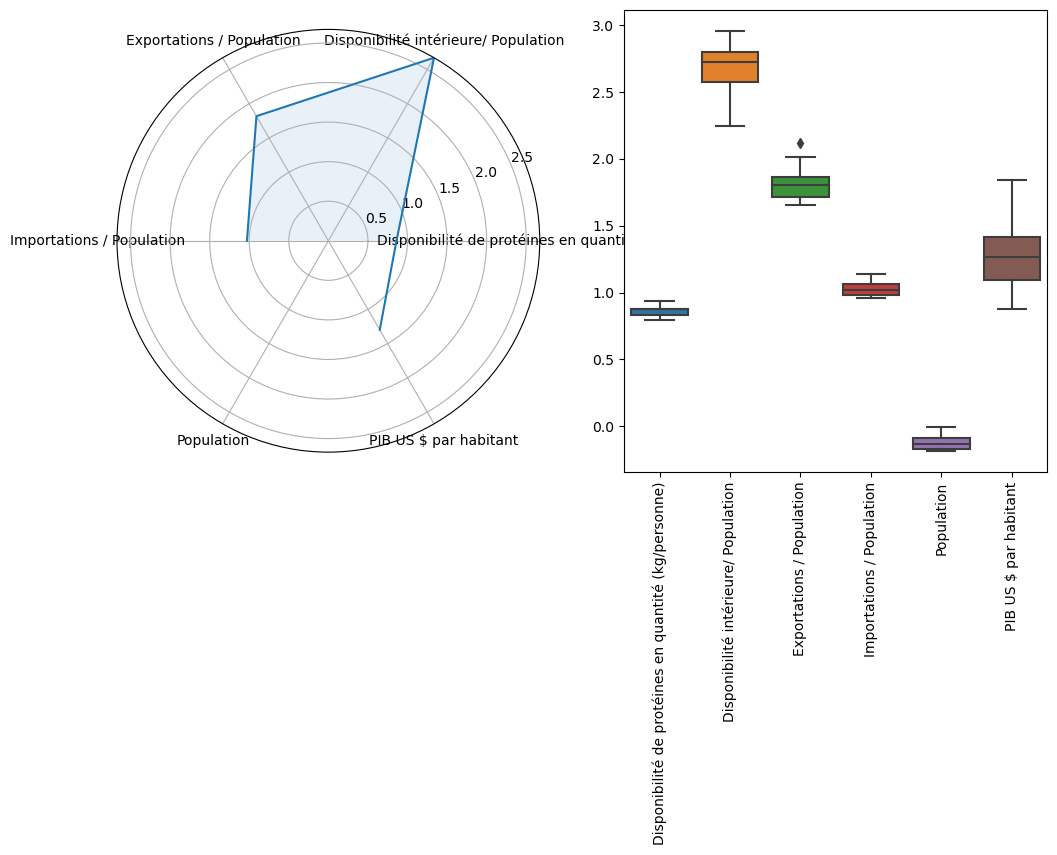

In [984]:
analyze_cluster(cluster_kmeans_dfs[3], 'cluster_kmeans', '3')

In [985]:
cluster_kmeans_dfs[3].describe()

,Disponibilité de protéines en quantité (kg/personne),Disponibilité intérieure/ Population,Exportations / Population,Importations / Population,Population,PIB US $ par habitant
count,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000
mean,0.860669,2.671339,1.818400,1.029009,-0.118692,1.298969
std,0.043910,0.213479,0.143485,0.056250,0.062002,0.296545
min,0.792072,2.247054,1.651689,0.956526,-0.182113,0.873986
25%,0.832656,2.574250,1.714147,0.985389,-0.167086,1.095616
50%,0.874505,2.725880,1.807270,1.019245,-0.129170,1.267286
75%,0.880531,2.798193,1.862246,1.064588,-0.086298,1.418399
max,0.938605,2.956018,2.116600,1.137712,-0.007604,1.843691


In [986]:
cluster_kmeans_dfs[3].head()

,Pays,cluster_kmeans,cluster_dd,Disponibilité de protéines en quantité (kg/personne),Disponibilité intérieure/ Population,Exportations / Population,Importations / Population,Population,PIB US $ par habitant
6,Antigua-et-Barbuda,3,9,0.849169,2.821454,1.807270,1.093384,-0.159170,1.267286
31,Chine - RAS de Macao,3,9,0.881069,2.371010,2.016504,0.978686,-0.019762,1.738056
40,Dominique,3,9,0.822718,2.774931,1.711780,1.051533,-0.166624,1.028518
52,Grenade,3,9,0.938605,2.762411,1.693417,0.956526,-0.129170,1.125371
82,Luxembourg,3,9,0.792072,2.247054,2.116600,1.034759,-0.007604,1.843691


### Cluster Kmeans 5

Boxplot et radarplot pour le cluster 4


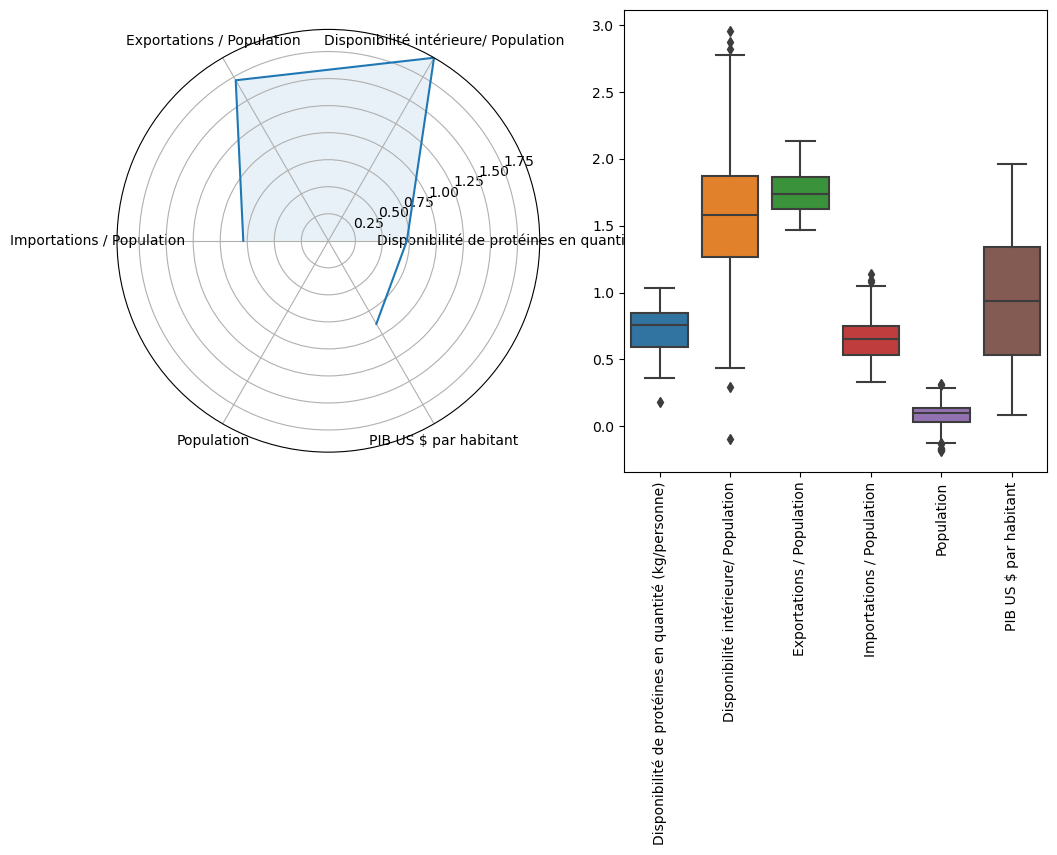

In [987]:
analyze_cluster(data_reconstructed, 'cluster_kmeans', '4')

In [988]:
cluster_5_kmeans.describe()

,Disponibilité de protéines en quantité (kg/personne),Disponibilité intérieure/ Population,Exportations / Population,Importations / Population,Population,PIB US $ par habitant
count,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000
mean,0.880469,1.606779,1.939866,0.634678,0.153481,1.542342
std,0.047630,0.297431,0.103464,0.089747,0.062057,0.226980
min,0.790512,0.971035,1.770550,0.427874,0.076344,1.147831
25%,0.857819,1.467332,1.885794,0.574028,0.115350,1.411619
50%,0.869624,1.641420,1.919565,0.646533,0.137620,1.520884
75%,0.917202,1.830462,1.981457,0.684848,0.177100,1.664722
max,0.989629,2.002046,2.135509,0.784414,0.308871,1.930626


In [989]:
cluster_5_kmeans.head()

,Pays,cluster_kmeans,cluster_dd,Disponibilité de protéines en quantité (kg/personne),Disponibilité intérieure/ Population,Exportations / Population,Importations / Population,Population,PIB US $ par habitant
8,Argentine,4,3,0.837940,1.416848,1.865972,0.555237,0.177356,1.325489
10,Australie,4,3,0.905863,1.636232,1.984197,0.648034,0.159199,1.668987
16,Belgique,4,3,0.873913,1.503939,2.125580,0.678385,0.195682,1.930626
21,Brésil,4,3,0.790512,0.976057,1.908459,0.427874,0.271728,1.343728
24,Bélarus,4,3,0.865335,1.669125,1.775610,0.599171,0.116374,1.173074


### Cluster Kmeans 6

Boxplot et radarplot pour le cluster 5


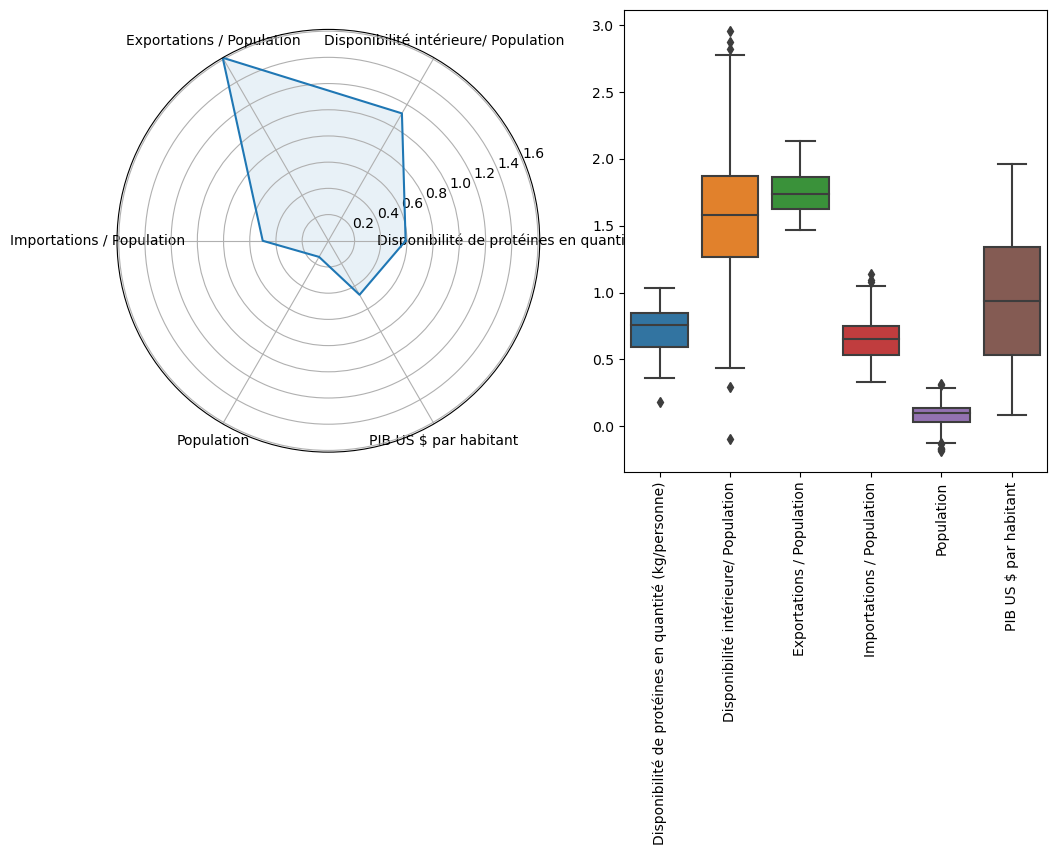

In [990]:
analyze_cluster(data_reconstructed, 'cluster_kmeans', '5')

In [991]:
cluster_6_kmeans.describe()

,Disponibilité de protéines en quantité (kg/personne),Disponibilité intérieure/ Population,Exportations / Population,Importations / Population,Population,PIB US $ par habitant
count,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000
mean,0.536044,1.300297,1.588760,0.600382,0.080536,0.367137
std,0.041455,0.256873,0.080330,0.084665,0.052604,0.182825
min,0.461785,0.916349,1.471070,0.472316,-0.013172,0.086174
25%,0.504191,1.027491,1.522564,0.528934,0.047073,0.250820
50%,0.540090,1.313727,1.579197,0.600987,0.072393,0.313677
75%,0.566873,1.485147,1.635550,0.672079,0.127808,0.455900
max,0.626679,1.764598,1.775350,0.742354,0.162734,0.806022


In [992]:
cluster_6_kmeans.head()

,Pays,cluster_kmeans,cluster_dd,Disponibilité de protéines en quantité (kg/personne),Disponibilité intérieure/ Population,Exportations / Population,Importations / Population,Population,PIB US $ par habitant
5,Angola,5,9,0.566873,1.313727,1.775350,0.665367,0.106955,0.806022
23,Burkina Faso,5,7,0.497998,1.018897,1.560741,0.500535,0.132454,0.250820
25,Bénin,5,6,0.590464,1.578847,1.580843,0.671835,0.030608,0.425274
27,Cambodge,5,7,0.501637,1.039562,1.647589,0.544220,0.137958,0.443011
38,Côte d'Ivoire,5,7,0.513822,0.972627,1.694790,0.528934,0.162734,0.556463


## Dendogramme

### Cluster Dendogramme 1

Boxplot et radarplot pour le cluster 3


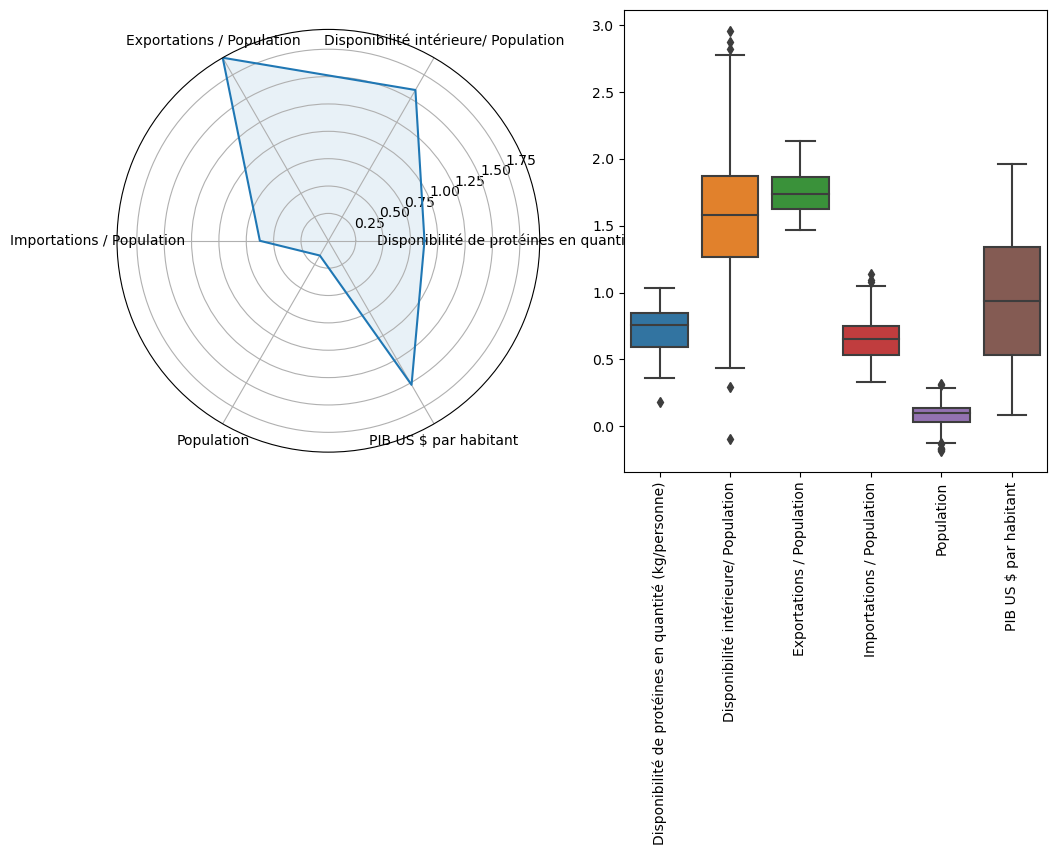

In [993]:
analyze_cluster(data_reconstructed, 'cluster_dd', '3')

In [994]:
cluster_1_dd.describe()

,Disponibilité de protéines en quantité (kg/personne),Disponibilité intérieure/ Population,Exportations / Population,Importations / Population,Population,PIB US $ par habitant
count,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000
mean,0.920065,2.188043,1.769167,0.768876,0.009579,1.244162
std,0.054227,0.223734,0.107019,0.085362,0.040673,0.234597
min,0.840772,1.762892,1.604299,0.624163,-0.048081,0.882581
25%,0.878172,2.058189,1.706483,0.714700,-0.018398,1.031372
50%,0.911663,2.191456,1.761490,0.770785,0.006502,1.271788
75%,0.953179,2.300319,1.859186,0.811908,0.040474,1.440075
max,1.035642,2.538532,1.934250,0.919598,0.078888,1.717612


In [995]:
cluster_1_dd.head()

,Pays,cluster_kmeans,cluster_dd,Disponibilité de protéines en quantité (kg/personne),Disponibilité intérieure/ Population,Exportations / Population,Importations / Population,Population,PIB US $ par habitant
13,Bahamas,6,1,0.957188,2.518288,1.854851,0.914383,-0.048081,1.485520
15,Barbade,7,1,1.035642,2.538532,1.733642,0.814352,-0.041161,1.317889
17,Belize,7,1,0.971603,2.308564,1.611198,0.712662,-0.019718,0.969475
32,Chypre,7,1,0.905278,2.177891,1.806439,0.791438,0.011321,1.306584
35,Costa Rica,7,1,0.851110,1.839578,1.762721,0.672982,0.070018,1.135176


Pays exportateur pas interessant

### Cluster Dendogramme 2

Boxplot et radarplot pour le cluster 3


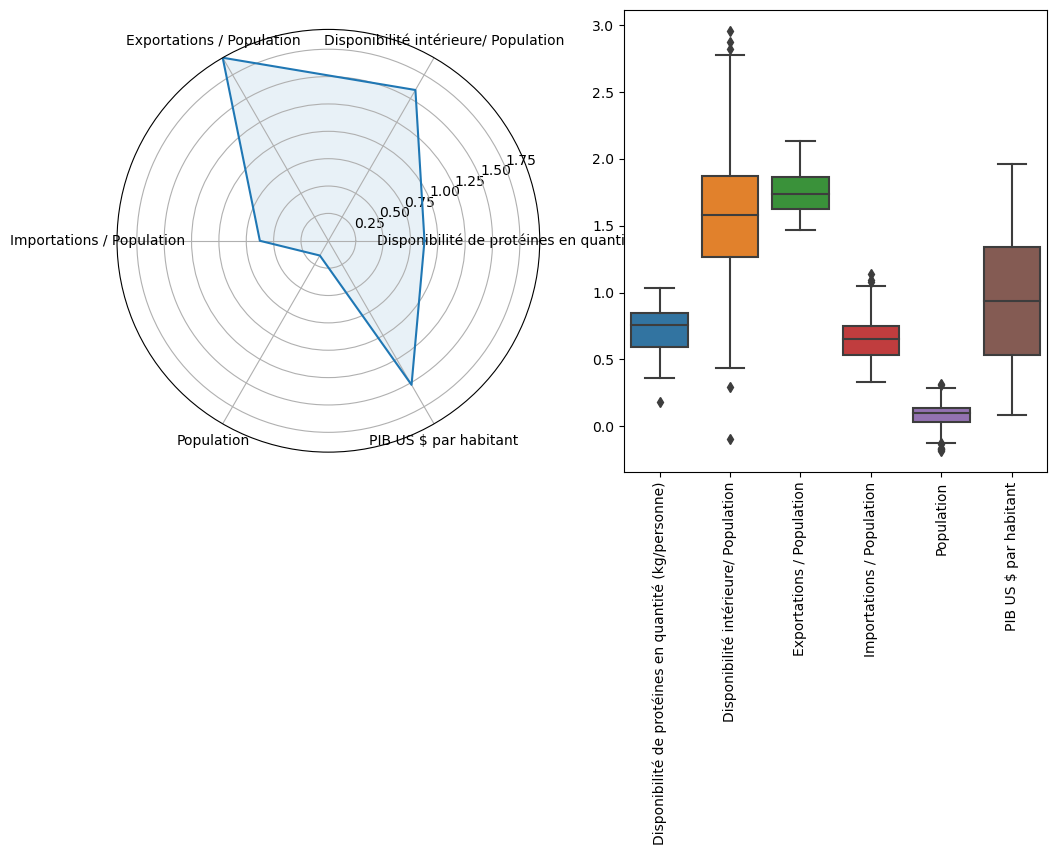

In [996]:
analyze_cluster(data_reconstructed, 'cluster_dd', '3')

In [997]:
cluster_2_dd.describe()

,Disponibilité de protéines en quantité (kg/personne),Disponibilité intérieure/ Population,Exportations / Population,Importations / Population,Population,PIB US $ par habitant
count,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000
mean,0.809884,1.596706,1.971057,0.694060,0.137010,1.525754
std,0.048935,0.215116,0.092184,0.064462,0.043865,0.232782
min,0.728323,1.188556,1.823192,0.578257,0.077335,1.204301
25%,0.784318,1.415054,1.893969,0.638170,0.109218,1.308833
50%,0.802084,1.675766,1.978305,0.706182,0.116771,1.534706
75%,0.825614,1.714809,2.041872,0.741459,0.174977,1.681578
max,0.920982,1.898973,2.112649,0.809605,0.220998,1.958214


In [998]:
cluster_2_dd.head()

,Pays,cluster_kmeans,cluster_dd,Disponibilité de protéines en quantité (kg/personne),Disponibilité intérieure/ Population,Exportations / Population,Importations / Population,Population,PIB US $ par habitant
4,Allemagne,0,2,0.761321,1.235927,2.097744,0.636756,0.220998,1.727164
7,Arabie saoudite,0,2,0.804393,1.657570,1.852123,0.670884,0.108124,1.265449
11,Autriche,0,2,0.835438,1.691271,2.059356,0.752964,0.131998,1.749851
22,Bulgarie,0,2,0.801644,1.770499,1.823192,0.706182,0.077335,1.204301
36,Croatie,0,2,0.794342,1.700557,1.869390,0.703008,0.096591,1.292453


peu de prod, pas d'exportations , bon cluster

### Cluster Dendogramme 3

Boxplot et radarplot pour le cluster 3


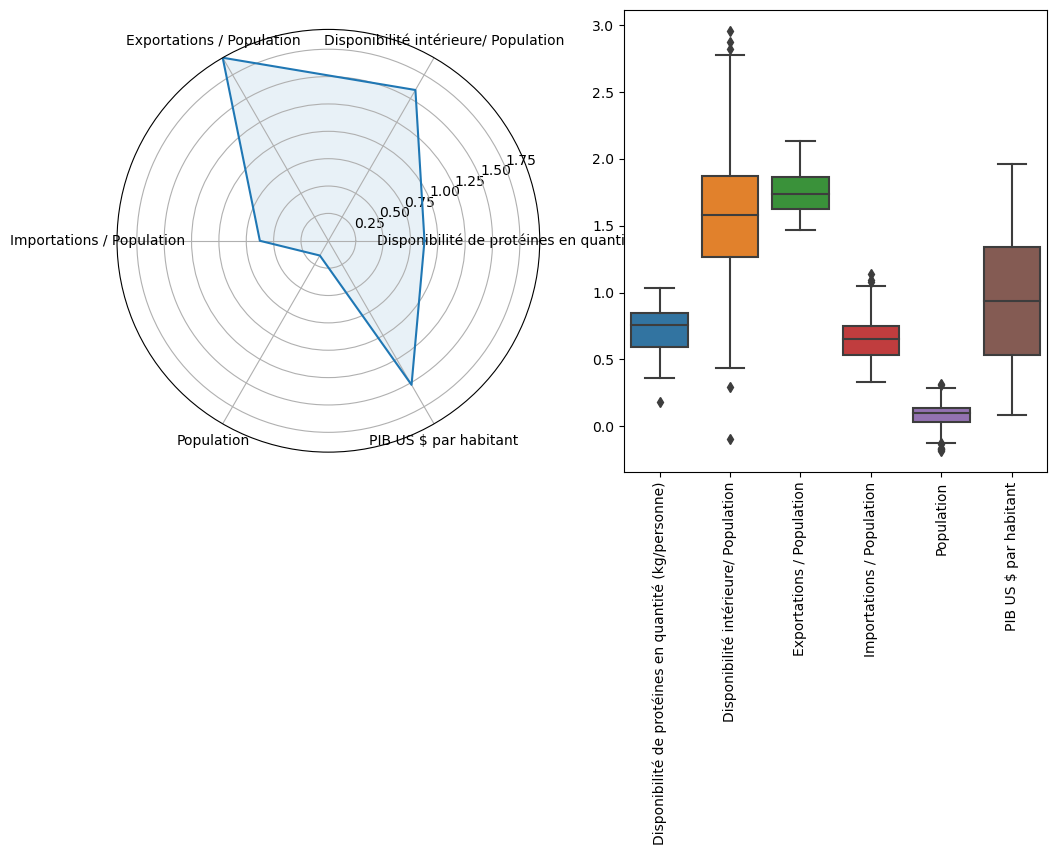

In [999]:
analyze_cluster(data_reconstructed, 'cluster_dd' , '3')

In [1000]:
cluster_3_dd.describe()

,Disponibilité de protéines en quantité (kg/personne),Disponibilité intérieure/ Population,Exportations / Population,Importations / Population,Population,PIB US $ par habitant
count,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000
mean,0.878086,1.590537,1.930958,0.625870,0.155641,1.519700
std,0.047977,0.298243,0.099277,0.084108,0.063266,0.211981
min,0.790512,0.971035,1.770550,0.427874,0.076344,1.147831
25%,0.856961,1.455130,1.881075,0.565646,0.115008,1.393539
50%,0.865335,1.636232,1.912377,0.645031,0.140216,1.496405
75%,0.905863,1.780798,1.973239,0.679882,0.177356,1.651925
max,0.989629,2.002046,2.135509,0.754237,0.308871,1.930626


In [1001]:
cluster_3_dd.head()

,Pays,cluster_kmeans,cluster_dd,Disponibilité de protéines en quantité (kg/personne),Disponibilité intérieure/ Population,Exportations / Population,Importations / Population,Population,PIB US $ par habitant
8,Argentine,4,3,0.837940,1.416848,1.865972,0.555237,0.177356,1.325489
10,Australie,4,3,0.905863,1.636232,1.984197,0.648034,0.159199,1.668987
16,Belgique,4,3,0.873913,1.503939,2.125580,0.678385,0.195682,1.930626
21,Brésil,4,3,0.790512,0.976057,1.908459,0.427874,0.271728,1.343728
24,Bélarus,4,3,0.865335,1.669125,1.775610,0.599171,0.116374,1.173074


Trop de prod

### CLuster 4 dendogramme

Boxplot et radarplot pour le cluster 4


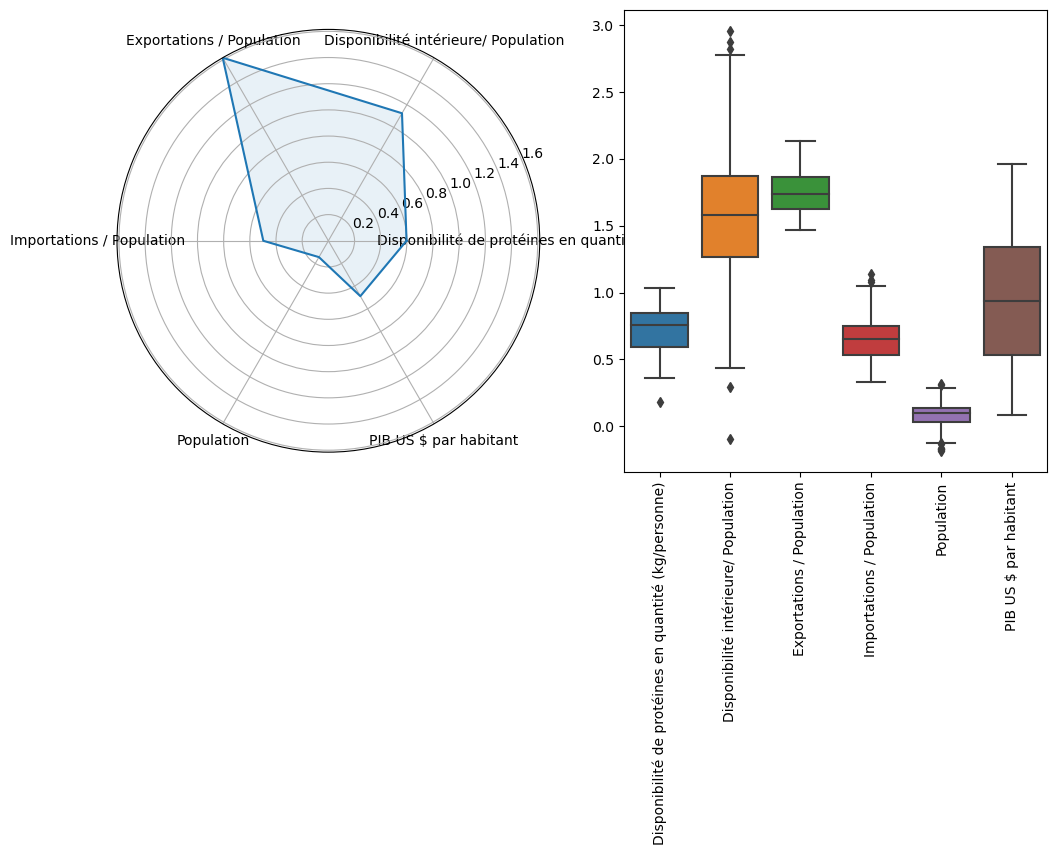

In [1002]:
analyze_cluster(data_reconstructed, 'cluster_dd', '4')

In [1003]:
cluster_4_dd.describe()

,Disponibilité de protéines en quantité (kg/personne),Disponibilité intérieure/ Population,Exportations / Population,Importations / Population,Population,PIB US $ par habitant
count,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000
mean,0.597221,1.124906,1.614794,0.497103,0.144231,0.488622
std,0.047091,0.269603,0.097818,0.073295,0.058028,0.218006
min,0.491027,0.528294,1.471680,0.355635,0.061599,0.169756
25%,0.587896,1.121482,1.540924,0.471877,0.116746,0.322552
50%,0.592396,1.211217,1.607366,0.510458,0.122281,0.478747
75%,0.620564,1.260708,1.658319,0.542381,0.155712,0.657960
max,0.663160,1.460393,1.786545,0.613355,0.282478,0.856295


In [1004]:
cluster_4_dd.head()

,Pays,cluster_kmeans,cluster_dd,Disponibilité de protéines en quantité (kg/personne),Disponibilité intérieure/ Population,Exportations / Population,Importations / Population,Population,PIB US $ par habitant
3,Algérie,8,4,0.592396,1.009162,1.747858,0.511392,0.184423,0.765028
62,Indonésie,8,4,0.527685,0.528294,1.786545,0.378279,0.282478,0.753098
86,Malawi,8,4,0.585408,1.211217,1.471680,0.478216,0.104729,0.169756
107,Pakistan,8,4,0.491027,0.633685,1.576693,0.355635,0.223507,0.261869
109,Paraguay,8,4,0.663160,1.386104,1.744569,0.613355,0.116746,0.856295


### Cluster 5 Dendogramme

Boxplot et radarplot pour le cluster 5


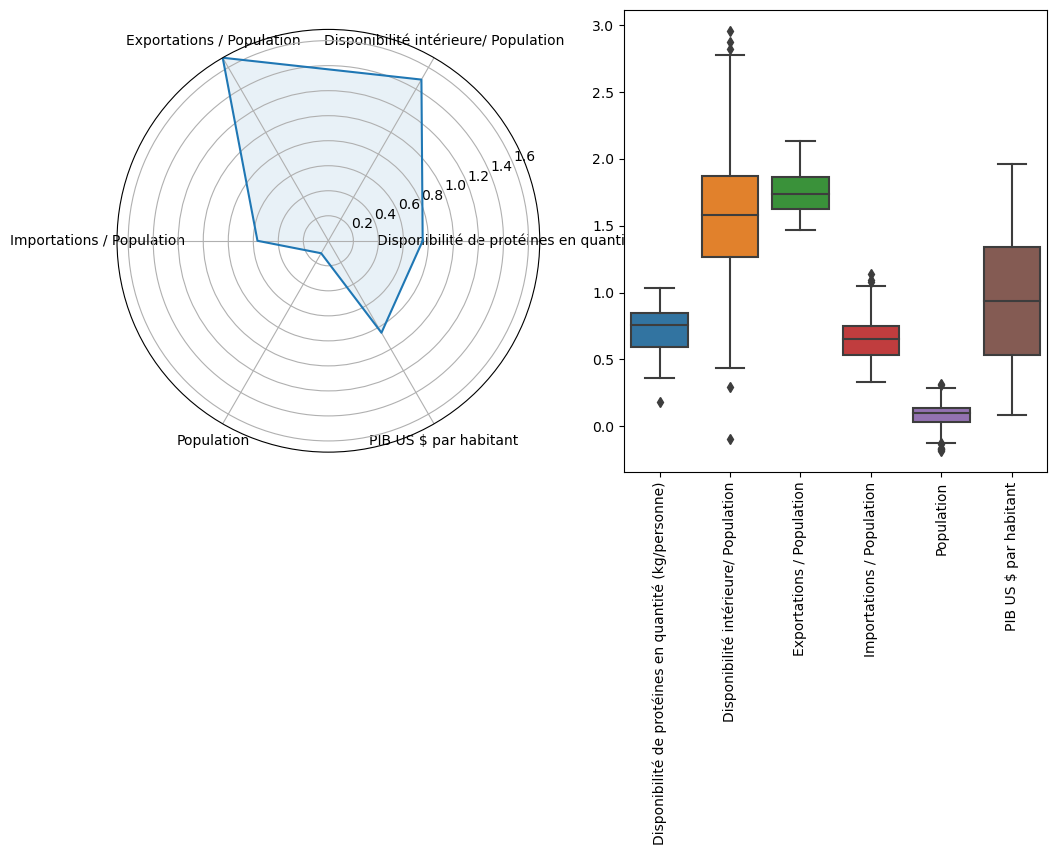

In [1005]:
analyze_cluster(data_reconstructed, 'cluster_dd', '5')

In [1006]:
cluster_5_dd.describe()

,Disponibilité de protéines en quantité (kg/personne),Disponibilité intérieure/ Population,Exportations / Population,Importations / Population,Population,PIB US $ par habitant
count,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000
mean,0.753773,1.487836,1.689581,0.566751,0.115193,0.848868
std,0.034414,0.219608,0.097475,0.065479,0.052675,0.191935
min,0.698381,1.008024,1.528519,0.446044,0.041306,0.467984
25%,0.730306,1.345089,1.625914,0.506915,0.073870,0.747136
50%,0.747917,1.513974,1.695157,0.576220,0.106597,0.844231
75%,0.777823,1.666439,1.755723,0.621986,0.137820,0.995205
max,0.836282,1.808777,1.874763,0.671278,0.229220,1.204627


In [1007]:
cluster_5_dd.head()

,Pays,cluster_kmeans,cluster_dd,Disponibilité de protéines en quantité (kg/personne),Disponibilité intérieure/ Population,Exportations / Population,Importations / Population,Population,PIB US $ par habitant
1,Afrique du Sud,9,5,0.784924,1.474886,1.753097,0.567141,0.134845,1.021983
12,Azerbaïdjan,9,5,0.716707,1.560311,1.694883,0.624757,0.086881,0.819339
18,Bolivie (État plurinational de),9,5,0.836282,1.708751,1.528519,0.528159,0.071446,0.608034
19,Bosnie-Herzégovine,9,5,0.805164,1.808777,1.713054,0.671278,0.057589,0.972705
33,Colombie,9,5,0.772156,1.440796,1.655509,0.519766,0.128515,0.795345


### CLuster 6 Dendogramme

Boxplot et radarplot pour le cluster 6


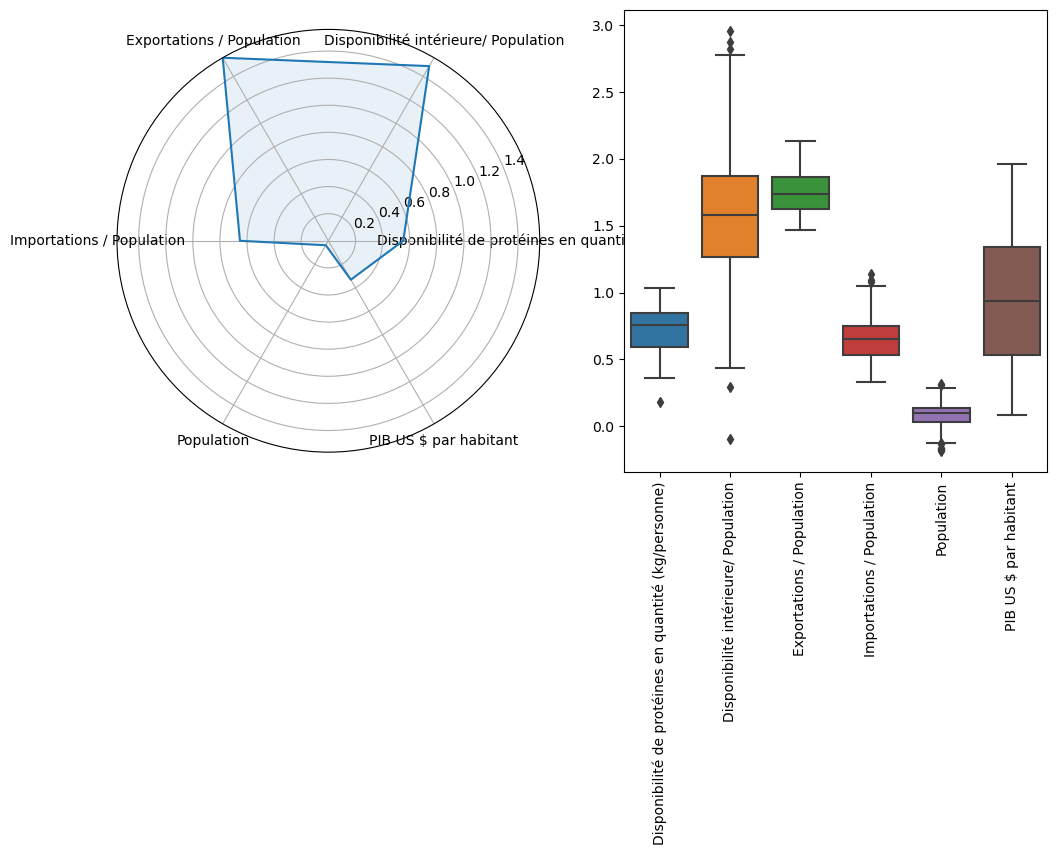

In [1008]:
analyze_cluster(data_reconstructed, 'cluster_dd', '6')

In [1009]:
cluster_6_dd.describe()

,Disponibilité de protéines en quantité (kg/personne),Disponibilité intérieure/ Population,Exportations / Population,Importations / Population,Population,PIB US $ par habitant
count,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000
mean,0.552743,1.488354,1.559737,0.652470,0.037999,0.331706
std,0.043748,0.171616,0.060040,0.055829,0.030439,0.133475
min,0.461785,1.265707,1.471070,0.560284,-0.013172,0.086174
25%,0.533607,1.335387,1.515502,0.628917,0.010122,0.238640
50%,0.550312,1.485147,1.579197,0.671835,0.047073,0.313677
75%,0.588720,1.582576,1.600073,0.676494,0.061534,0.433370
max,0.626679,1.764598,1.637551,0.742354,0.079349,0.520556


In [1010]:
cluster_6_dd.head()

,Pays,cluster_kmeans,cluster_dd,Disponibilité de protéines en quantité (kg/personne),Disponibilité intérieure/ Population,Exportations / Population,Importations / Population,Population,PIB US $ par habitant
25,Bénin,5,6,0.590464,1.578847,1.580843,0.671835,0.030608,0.425274
50,Gambie,5,6,0.550312,1.582576,1.515502,0.673259,0.010122,0.237233
55,Guinée,5,6,0.509374,1.265707,1.579197,0.600987,0.079349,0.313677
56,Guinée-Bissau,5,6,0.561300,1.485147,1.522564,0.628917,0.037484,0.261614
59,Haïti,5,6,0.542496,1.448417,1.635550,0.676494,0.052360,0.481348


# Sélection des pays

In [1011]:
cluster_2_dd.describe()

,Disponibilité de protéines en quantité (kg/personne),Disponibilité intérieure/ Population,Exportations / Population,Importations / Population,Population,PIB US $ par habitant
count,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000
mean,0.809884,1.596706,1.971057,0.694060,0.137010,1.525754
std,0.048935,0.215116,0.092184,0.064462,0.043865,0.232782
min,0.728323,1.188556,1.823192,0.578257,0.077335,1.204301
25%,0.784318,1.415054,1.893969,0.638170,0.109218,1.308833
50%,0.802084,1.675766,1.978305,0.706182,0.116771,1.534706
75%,0.825614,1.714809,2.041872,0.741459,0.174977,1.681578
max,0.920982,1.898973,2.112649,0.809605,0.220998,1.958214


In [1012]:
cluster_2_dd.head()

,Pays,cluster_kmeans,cluster_dd,Disponibilité de protéines en quantité (kg/personne),Disponibilité intérieure/ Population,Exportations / Population,Importations / Population,Population,PIB US $ par habitant
4,Allemagne,0,2,0.761321,1.235927,2.097744,0.636756,0.220998,1.727164
7,Arabie saoudite,0,2,0.804393,1.657570,1.852123,0.670884,0.108124,1.265449
11,Autriche,0,2,0.835438,1.691271,2.059356,0.752964,0.131998,1.749851
22,Bulgarie,0,2,0.801644,1.770499,1.823192,0.706182,0.077335,1.204301
36,Croatie,0,2,0.794342,1.700557,1.869390,0.703008,0.096591,1.292453
